<a href="https://colab.research.google.com/github/raamav/Text-Classification/blob/master/Twitter_for_PublicEmergencies_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Real or NOT" : NLP to Identify Public Emergency Related Tweets (Part One)


## Introduction

Being able to predict which Tweets are about real Public Emergencies (*eg Earthquakes, Floods, Terrorist Events*) and which ones are not. 

(The words 'Pubic Emergency' and 'Disasters' have been used interchangeably)

> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

> But, it’s not always clear whether a person’s words are actually announcing a disaster. 

<BR>

*Source: [Real or Not? NLP with Disaster Tweets, A Kaggle Competition](https://www.kaggle.com/c/nlp-getting-started/overview)*

<BR>

The dataset has the contents of the Tweet (`text` variable), the location from where the Tweet was posted (`location` variable), and a keyword associated with the Tweet (`keyword` variable). 

The model will be built based on the contents of the Tweet, as from a domain standpoint, the location and the keyword information may not always be available (in the situation this algorithm is actually deployed) 


<BR>

### Goal

This is the second exploration of the dataset. In the 1st attempt, I had used an ML based approach *(an ensemble of ensemble methods)* yielded 80% accuracy on the test data. 

The goal is to get a better model (~83%) using one or an ensemble of multiple Deep Learning models.


<BR>

### Approach & Results

In this notebook, I have tried out two variants of LSTM based approaches - one with pretrained embeddings and one without. The model which incorporate pre-trained embeddings from the Glove model had an accuracy of 83% on the test set.

I have also created a set of helper functions for data preprocessing, vocabulary building and creating embedding matrix from pre-trained embeddings.

The best performing model had an accuracy of 83% in the test data

<BR>

### Next Steps

The next step is to get better results by trying out a few more approaches which have been listed below. **These will be incorporated in the Second edition (Part 2) of the notebook.**

1. An `Ensemble` model (dense - word focussed + lstm - sequence focussed)
2. An `N-GRAM` model (especially n = 2)
3. Using `Attention` based frameworks
4. (Optional) A `Functional` model (using Keras functional API)


***
<BR>

## 1. Data Exploration & Pre-Processing

In [1]:
# STANDARD IMPORTS

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

tf.__version__


'2.2.0-rc3'

In [0]:
# A CUSTOM FUNCTION FOR CREATING WORDCLOUDS


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


def plot_wordcloud(text, max_words=400, 
                   min_font_size= 4 ,max_font_size=120,
                   min_word_lengthint = None,
                   figure_size=(24.0,16.0), 
                   title = None, title_size=40, 
                   mask = None):
    
    stopwords = set(STOPWORDS)
    
    more_stopwords = {'None'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    width = 1200,
                    height = 800,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    min_font_size = min_font_size,
                    random_state = 42,
                    mask = None)
    
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    


In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/raamav/Text-Classification/master/train.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


One of the first steps is to divide the data into training, validation and test sets. Will be adopting a 75 : 12.5 : 12.5 split for this purpose

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.25, random_state = 42)
val, test = train_test_split(test, test_size = 0.5, random_state = 42)

In [6]:
print("train.shape", train.shape)
print("val.shape", val.shape)
print("test.shape", test.shape)

train.shape (5709, 5)
val.shape (952, 5)
test.shape (952, 5)


Exploring the data, and building functions (and/or pipelines) for preprocessing data. Will also explore the possibility of crating features (although deep learning models do not require extensive feature engineering)

In [7]:
train.head(5)

,id,keyword,location,text,target
5151,7345,obliterate,"Dover, DE",@dicehateme @PuppyShogun This makes sense. Pap...,0
6351,9081,structural%20failure,"ÌÏT: 27.9136024,-81.6078532",'@CatoInstitute: The causes of federal failure...,0
3443,4920,exploded,"Elmwood Park, NJ",Well as I was chaning an iPad screen it fuckin...,0
7164,10265,war%20zone,Host of #MindMoversPodcast,the war on drugs has turned the U.S. into a WA...,1
7037,10083,typhoon,NaN,Obama Declares Disaster for Typhoon-Devastated...,1


In [8]:
# COUNTS OF NULL VALUES FOR VARIOUS VARIABLES

train.isnull().sum()

id             0
keyword       47
location    1886
text           0
target         0
dtype: int64

In [9]:
# SETTING THE NULL VALUES AS 'None'

train = train.fillna('None')
val = val.fillna('None')
test = test.fillna('None')

# RECHECKING NULL COUNT
print("\nTrain",train.isnull().sum())
print("\nVal",val.isnull().sum())
print("\nTest",test.isnull().sum())


Train id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Val id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Test id          0
keyword     0
location    0
text        0
target      0
dtype: int64


In [10]:
train.head(2)

,id,keyword,location,text,target
5151,7345,obliterate,"Dover, DE",@dicehateme @PuppyShogun This makes sense. Pap...,0
6351,9081,structural%20failure,"ÌÏT: 27.9136024,-81.6078532",'@CatoInstitute: The causes of federal failure...,0


The `id` variable isn't really needed so getting rid of it across all the datasets

In [0]:
train = train.drop('id',1)
val = val.drop('id',1)
test = test.drop('id',1)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709 entries, 5151 to 7270
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   5709 non-null   object
 1   location  5709 non-null   object
 2   text      5709 non-null   object
 3   target    5709 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 223.0+ KB


In [13]:
# WHICH ARE THE TOP KEYWORDS

keyword_var = pd.DataFrame(train['keyword'].value_counts())

keyword_var[1:21] # Excluding 'None' which is the top keyword



,keyword
siren,38
damage,36
fear,34
wreckage,34
fatalities,34
twister,33
deluge,33
harm,33
fatality,33
evacuate,32


In [14]:
# WHICH ARE THE TOP LOCATIONS

location_var = pd.DataFrame(train['location'].value_counts())

location_var[1:20] # Excluding 'None' which is the top keyword


,location
USA,83
New York,49
United States,40
London,37
Canada,25
UK,21
"Los Angeles, CA",19
Worldwide,18
Nigeria,18
Kenya,17


In [15]:
! pip install contractions
import contractions

     |████████████████████████████████| 245kB 3.7MB/s 
     |████████████████████████████████| 317kB 6.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81705 sha256=c1d23f85262751c6af361b591b777ae81d65dc1243e8bba0cabfc450998434d3
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
# FUNCTION TO IMPLEMENT BASIC TEXT PREPROCESSING : LOWER-CASING & REMOVING NUMBERS/PUNCTUATION

import re
import string
import contractions


def basic_preprocessor(text):
  
  import re
  import string
  import contractions
  

  # EXPANDING OUT CONTRACTIONS
  # e.g : don't -> do not
  text = contractions.fix(text)

  # TEXT TO LOWERCASE
  text = text.lower()

    
  # The syntax of re.sub() is:: re.sub(pattern, replace, source_string)
    
  # CODE TO HANDLE POSSESSIVES ('s) 
  # e.g: movie's -> movie s
  # THE HOPE IS THAT LSTMs SHOULD BE ABLE TO PROCESS "s" 
  text = re.sub(r"(\w+)'s", r'\1 s', text)
  
  # HANDLING OTHER PUNCTUATION
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
    
  return text

In [0]:
# EXPERIMENTING
sample = train.apply(lambda x: basic_preprocessor(x['text']),axis=1)


In [18]:
for i in range(1,11):
  print("\n", train['text'].iloc[i])
  print( sample.iloc[i])


 '@CatoInstitute: The causes of federal failure are deeply structural and they will not be easily solved: http://t.co/H2XcaX4jbU'
catoinstitute the causes of federal failure are deeply structural and they will not be easily solved 

 Well as I was chaning an iPad screen it fucking exploded and glass went all over the place. Looks like my job is going to need a new one.
well as i was chaning an ipad screen it fucking exploded and glass went all over the place looks like my job is going to need a new one

 the war on drugs has turned the U.S. into a WAR zone.
the war on drugs has turned the yous into a war zone

 Obama Declares Disaster for Typhoon-Devastated Saipan
obama declares disaster for typhoondevastated saipan

 According to prophecy and also CNN a Mac tablet will completely obliterate the need for other gadgets. CombiningÛ_ http://t.co/xfccvMXuWb
according to prophecy and also cnn a mac tablet will completely obliterate the need for other gadgets combiningû 

 Has body bagged

In [0]:
# PREPROCESSING THE TRAINING, VAL AND TEST SETS
train['text'] = train.apply(lambda x: basic_preprocessor(x['text']),axis=1)

val['text'] = val.apply(lambda x: basic_preprocessor(x['text']),axis=1)

test['text'] = test.apply(lambda x: basic_preprocessor(x['text']),axis=1)



Creating the initial model with just the text (contents of the tweet) variable.

In [0]:
X_train = train[['text']].copy()
y_train = train[['target']].copy()

X_val = val[['text']].copy()
y_val = val[['target']].copy()

X_test = test[['text']].copy()
y_test = test[['target']].copy()



## 2. Building and Understanding Vocabulary

In [0]:
# A FUNCTION THAT CONVERTS A LIST OF SENTENCES TO A VOCABULARY DICTIONARY

from tqdm import tqdm 


def build_vocab(sentences):

  """
  Purpose, Converts a list of sentences into a vocabulary dictionary
  Input, a list of sentences
  Prints, the size (length) of the vocabulary
  Returns, a vocabulary dictionary {word: frequency}
  """

  length = len(sentences)
  vocab ={}

  for s in tqdm(sentences):
    temp_list = []
    temp_list = s.split()

    for word in temp_list:
      if word not in vocab.keys():
        vocab[word] = 1
      else:
        vocab[word] += 1

  print("The size of the vocabulary is : ", len(vocab))

  return vocab

In [22]:
# CONVERTING THE TEXT FIELD INTO A LIST OF SENTENCES

sentences = []
m = len(X_train['text'])

for i in range(m):
  sentences.append(X_train['text'].iloc[i])

print("Number of sentences : ", len(sentences))


Number of sentences :  5709


In [23]:
# IMPLEMENTING WORD FREQUENCY FUNCTION, STORING RESULTS IN master_vocab VARIABLE
master_vocab = build_vocab(sentences)

100%|██████████| 5709/5709 [00:00<00:00, 231359.85it/s]

The size of the vocabulary is :  13932


In [24]:
# TOP 50 WORDS
print("\n")
print(sorted(master_vocab, key = lambda x: (-master_vocab[x], x))[0:50])




['the', 'a', 'to', 'in', 'of', 'i', 'and', 'is', 'you', 'for', 'on', 'not', 'it', 'my', 'that', 'with', 'are', 'at', 'by', 'have', 'this', 'from', 's', 'be', 'was', 'am', 'do', 'will', 'like', 'but', 'as', 'so', 'up', 'me', 'amp', 'we', 'just', 'your', 'out', 'no', 'can', 'after', 'has', 'all', 'when', 'an', 'fire', 'what', 'if', 'he']


In [0]:
# BLANK

## Using Pre-Trained Embeddings to Determine Extent of Data Standardization

In [26]:
# IMPORTING THE EMBEDDINGS
# THANKS TO: LAURENCE MORONEY, AI ADVOCATE AT GOOGLE 


!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

--2020-04-28 11:36:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  90.4MB/s    in 3.7s    

2020-04-28 11:36:18 (90.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [27]:
# PRINT OUT THE LENGTH OF THE DICTIONARY

print("Glove vocabulary size: ",len(embeddings_index))
print("Glove embedding dimensions: ",len(embeddings_index['the']))

Glove vocabulary size:  400000
Glove embedding dimensions:  100


In [0]:
# WRITING A FUNCTION TO DETERMINE THE OVERLAP BETWEEN THE 2 DICTIONARIES

from tqdm import tqdm
import operator

def check_overlap(vocab,embeddings):

  """
  Purpose, to determine the overlap between the corpus and the embeddings disctionary
  Inputs, 2 dictionaries, one for the vocabulary and the other for the corpus
  Prints, a set of useful information on the overlap
  Returns, a sorted version dictionary with out_of_vocabulary words and their frequency

  """
  
  not_in_glove = {}
  total_corpus_words = 0
  total_oov_words = 0

  for i in tqdm(vocab.keys()):
    total_corpus_words += vocab[i] 

    if i not in embeddings.keys():
      not_in_glove[i] = vocab[i]
      total_oov_words += vocab[i]

  x = len(not_in_glove)
  y = len(vocab)
  z = len(embeddings)

  print("\n\nVOCABULARY INSIGHTS:")
  print("The vocabulary size is (unique word-count) : ",y)
  print(f"Embeddings found for {y-x} ({round((y-x)*100/y,2)})% of the words")
  
  print("\nCORPUS INSIGHTS:")
  print("The corpus size is (total, non-unique word-count) : ",total_corpus_words)
  print(f"{total_oov_words} word(s), representing, {round(total_oov_words*100/total_corpus_words,2)}% of the corpus vocabulary is unmapped")

  print("\n Top 20 words by frequency that are not present in embeddings dictionary :")
  p = min(len(not_in_glove), 20)
  print(sorted(not_in_glove, key = lambda x: (-not_in_glove[x], x))[0:p])

  not_in_glove_sorted = sorted(not_in_glove.items(), key=operator.itemgetter(1))[::-1]
  

  return not_in_glove_sorted




In [29]:
# IMPLEMENTING THE FUCNTION

oov = check_overlap(master_vocab,embeddings_index)

100%|██████████| 13932/13932 [00:00<00:00, 973592.86it/s]



VOCABULARY INSIGHTS:
The vocabulary size is (unique word-count) :  13932
Embeddings found for 10137 (72.76)% of the words

CORPUS INSIGHTS:
The corpus size is (total, non-unique word-count) :  78758
4719 word(s), representing, 5.99% of the corpus vocabulary is unmapped

 Top 20 words by frequency that are not present in embeddings dictionary :
['\x89û', '\x89ûò', 'prebreak', 're\x89û', 'nowplaying', 'typhoondevastated', '\x89ûó', 'gbbo', 'bestnaijamade', 'disea', 'funtenna', 'lmao', 'subreddits', 'gtgt', '\x89ûïwhen', 'selfimage', 'yyc', 'abstorm', 'rea\x89û', 'sensorsenso']


It is quite-promising that 73% of words have corresponding entries in the embedding file.

Exploring the Top-50 OOV words

In [30]:
oov[0:50]

[('\x89û', 42),
 ('\x89ûò', 26),
 ('prebreak', 24),
 ('re\x89û', 22),
 ('nowplaying', 21),
 ('typhoondevastated', 20),
 ('\x89ûó', 19),
 ('gbbo', 17),
 ('bestnaijamade', 16),
 ('disea', 13),
 ('lmao', 13),
 ('funtenna', 13),
 ('subreddits', 13),
 ('gtgt', 11),
 ('\x89ûïwhen', 10),
 ('yyc', 9),
 ('selfimage', 9),
 ('rea\x89û', 8),
 ('worldnews', 8),
 ('abstorm', 8),
 ('sensorsenso', 8),
 ('sismo', 7),
 ('arianagrande', 7),
 ('mediterran', 7),
 ('spos', 7),
 ('rì©union', 7),
 ('justinbieber', 6),
 ('freakiest', 6),
 ('ices\x89û', 6),
 ('trapmusic', 6),
 ('djicemoon', 6),
 ('icemoon', 6),
 ('animalrescue', 6),
 ('don\x89ûªt', 6),
 ('truthnewsbbccnnislamtruthgodisisterrorismquranlies', 6),
 ('i\x89ûªm', 5),
 ('dorret', 5),
 ('tcot', 5),
 ('å£', 5),
 ('prophetmuhammad', 5),
 ('chicagoarea', 5),
 ('directioners', 5),
 ('mtvhottest', 5),
 ('wheavenly', 5),
 ('nasahurricane', 5),
 ('viralspell', 5),
 ('by\x89û', 5),
 ('usagov', 5),
 ('strategicpatience', 5),
 ('can\x89ûªt', 5)]

In [0]:
# DEFINE A MIS-SPELLING DICTIONARY

mispell_dict = {
  'prebreak': 'pre break',
  'nowplaying': 'now playing',
  'typhoondevastated': 'typhoon devastated',
  'lmao': 'funny'
}


In [0]:
# WRITING A FUNCTION TO CLEAN THE ABOVE INCONSISTENCIES
# AUTHOR: CRISTOF HENKEL, https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings


import re

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispellings, mispellings_re = _get_mispell(mispell_dict)



def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [0]:
# IMPLEMENTING THE FUNCTION FOR TRAINING AND TEST SETS

X_train["text"] = X_train["text"].apply(lambda x: replace_typical_misspell(x))
X_val["text"] = X_val["text"].apply(lambda x: replace_typical_misspell(x))
X_test["text"] = X_test["text"].apply(lambda x: replace_typical_misspell(x))


In [0]:
# BLANK

## Tokenizing Text


In [0]:
# SPECIFYING HYPERPARAMETERS

vocab_size = 7000
embedding_dim = 20
max_length = 15  
trunc_type = 'post'
oov_tok = "<OOV>"

In [36]:
# IMPORTING LIBRARIES AND SETTING-UP TOKENIZER

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
# IMPLEMENTING TOKENIZER

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

tokenizer.fit_on_texts(X_train['text'])

In [38]:
# PADDING SEQUENCES - TRAINING SET

X_train_seq = tokenizer.texts_to_sequences(X_train['text'])

print("length of the first training sequence: ",len(X_train_seq[0])) 
      
X_train_pad = pad_sequences(X_train_seq,maxlen = max_length, padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_train_pad[0])) 

length of the first training sequence:  22
length of the first training sequence (PADDED):  15


In [39]:
# TOKENIZATION AND PADDING ON VALIDATION DATA

X_val_seq = tokenizer.texts_to_sequences(X_val['text'])

print("length of the first test sequence: ",len(X_val_seq[0])) 
      
X_val_pad = pad_sequences(X_val_seq, padding = 'post',maxlen = max_length, truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_val_pad[0])) 


length of the first test sequence:  17
length of the first training sequence (PADDED):  15


In [40]:
# TOKENIZATION AND PADDING ON TEST DATA

X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

print("length of the first test sequence: ",len(X_test_seq[0])) 
      
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length,padding = 'post', truncating = trunc_type)

print("length of the first training sequence (PADDED): ",len(X_test_pad[0])) 


length of the first test sequence:  21
length of the first training sequence (PADDED):  15


In [41]:
print(type(X_train_pad))
print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)

<class 'numpy.ndarray'>
(5709, 15)
(952, 15)
(952, 15)


In [42]:
X_train_pad[0:3]

array([[5188, 5189,   22,  746, 1095, 2140, 2632, 1011, 2140, 1096,   23,
        2633,   33, 2633,  140],
       [5190,    2,  943,    6, 5191,  318,   18, 5192,  442,    8,   53,
          28,   13,   25, 2141],
       [ 232,   32,    7,   26, 5194,   48, 3448, 1441,   14,  244,  443,
           8, 1097,  417,   45]], dtype=int32)

## LSTM BASED MODEL

In [43]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS


sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 18


lstm_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size + 1,
                                         output_dim = embedding_dim,
                                         input_length = sentence_length),
                          
                  
                  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True, dropout = 0.2, recurrent_dropout= 0.2)),
                  keras.layers.Bidirectional(keras.layers.LSTM(32)),


                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(32, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 20)            140020    
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           43520     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [44]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("twtr_lstm_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_1 = lstm_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
179/179 [==============================] - 22s 122ms/step - loss: 0.7127 - accuracy: 0.6027 - val_loss: 0.6437 - val_accuracy: 0.7090
Epoch 2/20
179/179 [==============================] - 21s 120ms/step - loss: 0.4422 - accuracy: 0.8099 - val_loss: 0.5292 - val_accuracy: 0.7836
Epoch 3/20
179/179 [==============================] - 21s 118ms/step - loss: 0.3382 - accuracy: 0.8632 - val_loss: 0.4776 - val_accuracy: 0.7857
Epoch 4/20
179/179 [==============================] - 21s 118ms/step - loss: 0.2657 - accuracy: 0.8975 - val_loss: 0.5871 - val_accuracy: 0.7763
Epoch 5/20
179/179 [==============================] - 21s 116ms/step - loss: 0.2359 - accuracy: 0.9128 - val_loss: 0.7322 - val_accuracy: 0.6996
Epoch 6/20
179/179 [==============================] - 21s 117ms/step - loss: 0.1905 - accuracy: 0.9310 - val_loss: 0.6328 - val_accuracy: 0.7437
Epoch 7/20
179/179 [==============================] - 21s 116ms/step - loss: 0.1689 - accuracy: 0.9382 - val_loss: 0.6393 - val_ac

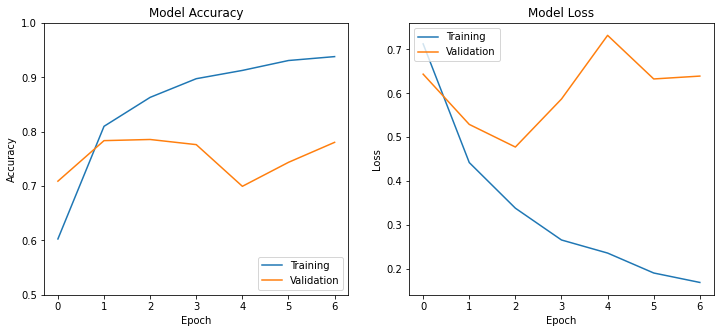

In [45]:
history = history_1


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')

In [46]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('twtr_lstm_best.h5')

best_model.evaluate(X_test_pad, y_test)

30/30 [==============================] - 0s 10ms/step - loss: 0.4528 - accuracy: 0.8067


[0.4528295695781708, 0.8067227005958557]

In [0]:
# BLANK

## LSTM MODEL WITH PRE-TRAINED EMBEDDINGS

In [0]:
# A FUNCTION TO GENERATE EMBEDDINGS_MATRIX


def gen_embeddings_matrix(max_features, word_index,embeddings_index):

  """
  Purpose, to generate embedding_matrix
  Inputs, no of features, word_index and embeddings_index
  Returns, embedding_matrix of size (max_features * embedding_dims)

  """

  # CONVERTING THE EMBEDDINGS DIMENSIONS TO NUMPY (100 d)
  all_emb_dims = np.stack(embeddings_index.values())

  # CALCULATING MEAN AND SD FOR THE DIMENSIONS
  emb_mean = all_emb_dims.mean()
  emb_std = all_emb_dims.std()

  # NO OF EMBEDDING DIMENSIONS
  embed_size = all_emb_dims.shape[1]

  # EFFECTIVE VOCAB SIZE
  no_words = min(max_features, len(word_index)) # no of words

  # CREATING AN EMBEDDINGS MATRIX
  # INITIALIZING IT WITH MEAN AND SD VALUES (EMBEDDINGS INDEX)
  np.random.seed(42)
  embedding_matrix = np.random.normal(emb_mean, emb_std, (no_words, embed_size))

  # LOGIC TO CHECK AND POPULATE EMBEDDING MATRIX

  for word in word_index.keys():
    
    # IGNORE IF WORD IS "BEYOND" THE FREQ RANGE
    if word_index[word] >= max_features: 
      continue

    # CHECK IF WORD IS IN THE EMBEDDINGS_INDEX OR IS AN OOV WORD
    if word in embeddings_index.keys(): 
      embedding_vector = embeddings_index[word]
      embedding_matrix[word_index[word]] = embedding_vector

  return embedding_matrix


In [49]:
# IMPLEMENTING THE FUNCTION TO GENERATE EMBEDDINGS MATRIX

max_features = vocab_size
word_index = tokenizer.word_index

embedding_matrix = gen_embeddings_matrix(max_features, word_index,embeddings_index)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
# IMP: TO CONCLUSIVELY ESTABLISH THE LINK BETWEEN word_index, embeddings_index AND embeddings_matrix

word_index['the'] # equals 2

# IMP: CHECK IF embeddings_index[2] = embedding_matrix[2] = embeddings FOR 'the' WORD
print(np.all(embeddings_index['the'] == embedding_matrix[2] ))

True


In [53]:
# BLANK

100

In [55]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS

#vocab_size = vocab_size   # NUMBER OF UNIQUE WORDS IN VOCAB = 10,000 
#embedding_dim = embedding_dim
sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 175
embed_size = embedding_matrix.shape[1]


lstm_emb_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embed_size,
                                         input_length = sentence_length,
                                         weights=[embedding_matrix], trainable= False),
                          
                  keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True, recurrent_dropout = 0.2, dropout = 0.2)),
                  keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True, recurrent_dropout= 0.2, dropout = 0.2)),
                  keras.layers.Bidirectional(keras.layers.LSTM(32)),


                  #keras.layers.GlobalAveragePooling1D(),

                  keras.layers.Dense(128, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(32, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
lstm_emb_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           700000    
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 128)           164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [56]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("twtr_lstm_emb_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

lstm_emb_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_3 = lstm_emb_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
179/179 [==============================] - 39s 215ms/step - loss: 0.5761 - accuracy: 0.7161 - val_loss: 0.5148 - val_accuracy: 0.7752
Epoch 2/20
179/179 [==============================] - 37s 208ms/step - loss: 0.5113 - accuracy: 0.7616 - val_loss: 0.5460 - val_accuracy: 0.6429
Epoch 3/20
179/179 [==============================] - 37s 206ms/step - loss: 0.4717 - accuracy: 0.7909 - val_loss: 0.5265 - val_accuracy: 0.7731
Epoch 4/20
179/179 [==============================] - 37s 207ms/step - loss: 0.4690 - accuracy: 0.7937 - val_loss: 0.4360 - val_accuracy: 0.8004
Epoch 5/20
179/179 [==============================] - 37s 207ms/step - loss: 0.4586 - accuracy: 0.7989 - val_loss: 0.4993 - val_accuracy: 0.7731
Epoch 6/20
179/179 [==============================] - 37s 207ms/step - loss: 0.4438 - accuracy: 0.8050 - val_loss: 0.5420 - val_accuracy: 0.7111
Epoch 7/20
179/179 [==============================] - 37s 204ms/step - loss: 0.4473 - accuracy: 0.8049 - val_loss: 0.4635 - val_ac

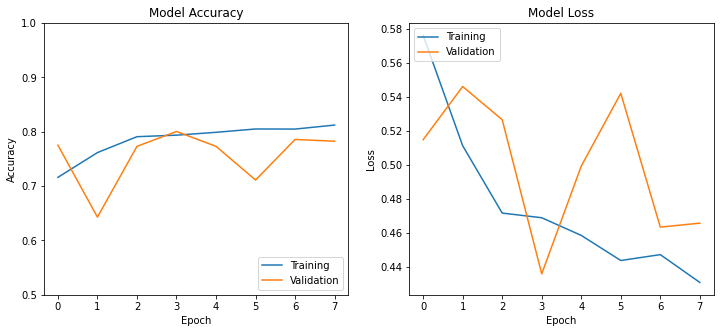

In [57]:
history = history_3


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')

In [58]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('twtr_lstm_emb_best.h5')

best_model.evaluate(X_test_pad, y_test)

30/30 [==============================] - 0s 16ms/step - loss: 0.4485 - accuracy: 0.8015


[0.4485025405883789, 0.8014705777168274]

In [0]:
# BLANK

## Dense Model 



In [60]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# CREATE AN LSTM BASED NEURAL NETWORK IN KERAS


sentence_length = max_length  # LENGTH OF EACH PADDED SENTENCE = 18


dense_model = keras.models.Sequential([
                                          
                  keras.layers.Embedding(input_dim = vocab_size + 1,
                                         output_dim = embedding_dim,
                                         input_length = sentence_length),
                          
                  
                  keras.layers.GlobalMaxPooling1D(),

                  keras.layers.Dense(256, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(128, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(64, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(32, activation = "relu"),
                  keras.layers.Dropout(rate = 0.2),
                  keras.layers.BatchNormalization(),

                  keras.layers.Dense(1, activation = "sigmoid")
                  
])



# VIEW MODEL ARCHITECTURE
dense_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 20)            140020    
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [61]:
# IMPLEMENT CALLBACKS

checkpoint_cb = keras.callbacks.ModelCheckpoint("twtr_dense_best.h5",save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

dense_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])

history_4 = dense_model.fit(X_train_pad,y_train, epochs = 20,
                            validation_data = (X_val_pad, y_val),
                            callbacks = [checkpoint_cb, early_stopping_cb]
                            
                            )

Epoch 1/20
179/179 [==============================] - 1s 8ms/step - loss: 0.7898 - accuracy: 0.5190 - val_loss: 0.6800 - val_accuracy: 0.5683
Epoch 2/20
179/179 [==============================] - 1s 7ms/step - loss: 0.6042 - accuracy: 0.6812 - val_loss: 0.6418 - val_accuracy: 0.5956
Epoch 3/20
179/179 [==============================] - 1s 7ms/step - loss: 0.4720 - accuracy: 0.7945 - val_loss: 0.5125 - val_accuracy: 0.7626
Epoch 4/20
179/179 [==============================] - 1s 7ms/step - loss: 0.3701 - accuracy: 0.8474 - val_loss: 0.5367 - val_accuracy: 0.7700
Epoch 5/20
179/179 [==============================] - 1s 6ms/step - loss: 0.3138 - accuracy: 0.8756 - val_loss: 0.5926 - val_accuracy: 0.7489
Epoch 6/20
179/179 [==============================] - 1s 7ms/step - loss: 0.2546 - accuracy: 0.9063 - val_loss: 0.6062 - val_accuracy: 0.7563
Epoch 7/20
179/179 [==============================] - 1s 6ms/step - loss: 0.2182 - accuracy: 0.9198 - val_loss: 0.6631 - val_accuracy: 0.7595


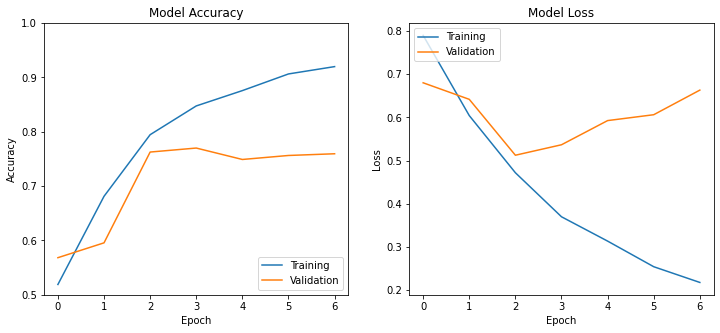

In [62]:
history = history_4


# BETTER LOOKING PLOTS FOR ACCURACY AND LOSS

import matplotlib.pyplot as plt

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_ylim([0.5,1])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper left')

In [63]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
best_model = keras.models.load_model('twtr_dense_best.h5')

best_model.evaluate(X_test_pad, y_test)

30/30 [==============================] - 0s 2ms/step - loss: 0.4956 - accuracy: 0.7836


[0.49564316868782043, 0.7836134433746338]

In [0]:
# BLANK

## Concluding Remarks
In this notebook, I have tried out two variants of LSTM based approaches - one with pretrained embeddings and one without. The model which incorporate pre-trained embeddings from the Glove model had an accuracy of 83% on the test set.

I have also created a set of helper functions for data preprocessing, vocabulary building and creating embedding matrix from pre-trained embeddings.

<BR>

## Next Steps

The next step is to get better results by trying out a few more approaches which have been listed below.

1. An `Ensemble` model (dense - word focussed + lstm - sequence focussed)
2. An `N-GRAM` model (especially n = 2)
3. Using `Attention` based frameworks
4. (Optional) A `Functional` model (using Keras functional API)

In [0]:
# LOAD THE BEST PERFORMING MODEL (SO FAR.)
lstm_emb_model = keras.models.load_model('twtr_lstm_emb_best.h5')
dense_model = keras.models.load_model('twtr_dense_best.h5')

Y_lstm_emb = lstm_emb_model.predict(X_test, verbose = True)
Y_dense = dense_model.predict(X_test, verbose = True)


## Appendix: MERGED MODEL (Ensemble of Deep Learning Models)

*work in progress*

In [0]:
# CLEAR BACKEND DATA

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# TREE 1
input_AA = keras.layers.Input(shape=(sentence_length,), dtype='int32') # THIS HAS TO BE ADDED FOR IT TO WORK
input_A = keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embed_size,
                                         input_length = sentence_length,
                                         weights=[embedding_matrix], trainable= False) (input_AA)

A_hidden_1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences= True, recurrent_dropout = 0.2, dropout = 0.2)) (input_A)
A_hidden_2 = keras.layers.Bidirectional(keras.layers.LSTM(64, recurrent_dropout = 0.2, dropout = 0.2)) (A_hidden_1)


# TREE 2
input_BB = keras.layers.Input(shape=(sentence_length,), dtype='int32') # THIS HAS TO BE ADDED FOR IT TO WORK
input_B = keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embed_size,
                                         input_length = sentence_length)(input_BB)

B_hidden_1 = keras.layers.GlobalMaxPooling1D()(input_B) 

B_hidden_2 = keras.layers.Dense(128, activation = "relu")(B_hidden_1)
B_hidden_3 = keras.layers.Dropout(rate = 0.2)(B_hidden_2)
B_hidden_4 = keras.layers.BatchNormalization()(B_hidden_3)

B_hidden_5 = keras.layers.Dense(64, activation = "relu")(B_hidden_4)
B_hidden_6 = keras.layers.Dropout(rate = 0.2)(B_hidden_5)
B_hidden_7 = keras.layers.BatchNormalization()(B_hidden_6)

# COMBINING STEP
concat = keras.layers.concatenate([A_hidden_2,B_hidden_7])

dense_1 = keras.layers.Dense(20, activation = "relu")(concat)
dense_2 = keras.layers.Dropout(rate = 0.2)(dense_1)
dense_3 = keras.layers.BatchNormalization()(dense_2)

output = keras.layers.Dense(1,activation = "softmax")(dense_3)


merged_model = keras.Model(inputs = [input_AA,input_BB], outputs = [output])



# VIEW MODEL ARCHITECTURE
merged_model.summary()


In [0]:
# IMPLEMENT CALLBACKS

# checkpoint_cb = keras.callbacks.ModelCheckpoint("twtr_merged_best.h5",save_best_only = True)

# early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)




# COMPILE AND FIT MODEL

# merged_model.compile(optimizer = "adam", loss = ["binary_crossentropy","binary_crossentropy"], metrics = ['accuracy'])

# history_5 = merged_model.fit((X_train_pad,X_train_pad),y_train, epochs = 20,
#                             validation_data = ((X_val_pad,X_val_pad), y_val),
#                             callbacks = [checkpoint_cb, early_stopping_cb]
                            
#                             )